In [1]:
# import packages
import glob
from pathlib import Path
import os
import numpy as np
from datetime import datetime
from datetime import timedelta
import pandas as pd
import calendar
import geopandas as gpd
# import cartopy
import matplotlib.pyplot as plt
import math
from pathos.threading import ThreadPool as Pool
from scipy.optimize import least_squares
import sklearn
from sklearn.linear_model import LinearRegression
from scipy.stats import gaussian_kde
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
import random
from scipy.optimize import minimize
import matplotlib as mpl
from matplotlib import cm
import cartopy.crs as ccrs
import cartopy

In [2]:
# define your script working directory
work_dir=Path("/mnt/u/LSM root zone/global_sr/")

In [3]:
from f_catch_characteristics import *

### 1. compute catchment characteristics - climate and snow

In [4]:
# define climate and snow variables 
var_cl=['p_mean','ep_mean','q_mean','t_mean','ai','hai','tdiff_max','tdiff_mean','idu_mean','idu_max','hpd_mean','hpd_max','hpf','lpf','si_p','si_ep','phi','de','dp','dt','sp','st','se','sd','sti','ftf','asi','cvp']
var_sn=['idu_mean_l','idu_max_l','hpd_mean_l','hpd_max_l','hpf_l','lpf_l','si_pl','phi_l','de_l','dp_l','dt_l','sp_l','st_l','se_l','sd_l','sti_l','asi_l']

# catchment id list
catch_id_list = np.genfromtxt(f'{work_dir}/output/gsim_aus_catch_id_list_lo_sel_area_wb.txt',dtype='str')[:] 
data_sources = 'gswp-p_gleam-ep_gswp-t'

In [17]:
# check which catchments are missing
el_id_list=[]
for filepath in glob.iglob(f'{work_dir}/output/catchment_characteristics/{data_sources}/climate/*.csv'):
    f = os.path.split(filepath)[1] # remove full path
    f = f[:-4] # remove .year extension
    el_id_list.append(f)
dif = list(set(catch_id_list) - set(el_id_list))
len(dif)

1

In [ ]:
# make lists for parallel computation
catch_list = dif[0:300]
# catch_list = catch_id_list
var_cl_list = [var_cl] * len(catch_list)
var_sn_list = [var_sn] * len(catch_list)
work_dir_list = [work_dir] * len(catch_list)
data_sources_list = [data_sources] * len(catch_list)

# run catch_characteristics (defined in f_catch_characteristics.py) for the catchments in your catch_id_list parallel
run_function_parallel_catch_characteristics(var_cl_list,var_sn_list,catch_list,work_dir_list,data_sources_list)
print('done')

### 2. compute catchment characteristics - landscape

In [4]:
var_lc=['tc','ntc','nonveg','area','el_mean','el_min','el_max','el_std','slp_mean','slp_max','slp_min','slp_std','iwu','ia','kg','lat','lon','bp','dtb','pclay','psand','pcarb','bulk','stext']
# catchment id list
catch_id_list = np.genfromtxt(f'{work_dir}/output/gsim_aus_catch_id_list_lo_sel_area_wb.txt',dtype='str')[:] 
data_sources = 'gswp-p_gleam-ep_gswp-t'

In [34]:
# check which catchments are missing
el_id_list=[]
for filepath in glob.iglob(f'{work_dir}/output/catchment_characteristics/{data_sources}/landscape/*.csv'):
    f = os.path.split(filepath)[1] # remove full path
    f = f[:-4] # remove .year extension
    el_id_list.append(f)
dif = list(set(catch_id_list) - set(el_id_list))
len(dif)

1547

In [35]:
# make lists for parallel computation
catch_list = dif[0:2000]
var_lc_list = [var_lc] * len(catch_list)
work_dir_list = [work_dir] * len(catch_list)
data_sources_list = [data_sources] * len(catch_list)

# run catch_characteristics (defined in f_catch_characteristics.py) for the catchments in your catch_id_list parallel
run_function_parallel_catch_characteristics_lc(var_lc_list,catch_list,work_dir_list,data_sources_list)
print('done')

done


In [ ]:
## test landscape script - potentially add other variables here!

In [36]:
# var_lc=['tc','ntc','nonveg','area','ia','el_mean','el_min','el_max','el_std','drd','slp_mean','slp_max','slp_min','slp_std','cla','snd','slt','tpi','bp','dtb','iwu','ds','dv','pd','pop','nld','clt','lc','lit']
var_lc=['tc','ntc','nonveg','area','el_mean','el_min','el_max','el_std','slp_mean','slp_max','slp_min','slp_std','iwu','ia','kg','lat','lon','bp','dtb','pclay','psand','pcarb','bulk','stext']
# catchment id list
catch_id_list = np.genfromtxt(f'{work_dir}/output/gsim_aus_catch_id_list_lo_sel_area_wb.txt',dtype='str')[:] 
data_sources = 'gswp-p_gleam-ep_gswp-t'
catch_id = catch_id_list[10]
catch_id

'us_0006289'

In [37]:
cc_lc = pd.DataFrame(index=[catch_id], columns=var_lc)
j = catch_id

if 'tc' in var_lc:
    dft = pd.read_csv(f'{work_dir}/output/treecover/gsim_shapes_treecover_italy.csv',index_col=0) #find treecover tables for catchment
    cc_lc.loc[j,'tc'] = dft.loc[j,'mean_tc'] /100
    cc_lc.loc[j,'ntc'] = dft.loc[j,'mean_ntc']/100
    cc_lc.loc[j,'nonveg'] = dft.loc[j,'mean_nonveg']/100

if 'area' in var_lc:
    a = pd.read_csv(f'{work_dir}/output/catchment_area.csv',index_col=0)
    cc_lc.loc[j,'area'] = a.loc[j,'area']

if 'el_mean' in var_lc:
    e = pd.read_csv(f'{work_dir}/output/elevation/stats_hydrosheds/ele_{j}.csv',index_col=0)
    e.index = e.index.map(str)
    cc_lc.loc[j,'el_mean'] = e.loc[j,'mean_ele']
    cc_lc.loc[j,'el_max'] = e.loc[j,'max_ele']
    cc_lc.loc[j,'el_min'] = e.loc[j,'min_ele']
    cc_lc.loc[j,'el_std'] = e.loc[j,'std_ele']
if 'slp_mean' in var_lc:
    e = pd.read_csv(f'{work_dir}/output/elevation/stats_hydrosheds/slope_{j}.csv',index_col=0)
    e.index = e.index.map(str)
    cc_lc.loc[j,'slp_mean'] = e.loc[j,'mean_slope']
    cc_lc.loc[j,'slp_max'] = e.loc[j,'max_slope']
    cc_lc.loc[j,'slp_min'] = e.loc[j,'min_slope']
    cc_lc.loc[j,'slp_std'] = e.loc[j,'std_slope']
    
if 'iwu' in var_lc:
    e = pd.read_csv(f'{work_dir}/output/irrigation/processed2/mean/{j}.csv',index_col=0)
    e.index = e.index.map(str)
    cc_lc.loc[j,'iwu'] = e.loc[j,'iwu_mean_mmday']
    
if 'ia' in var_lc:
    e = pd.read_csv(f'{work_dir}/data/irrigated_area/output/combined_ia.csv',index_col=0)
    e.index = e.index.map(str)
    cc_lc.loc[j,'ia'] = e.loc[j,'hi']
        
if 'kg' in var_lc:
    e = pd.read_csv(f'{work_dir}/data/koppen_climates/all_catch_table_kg_climates.csv',index_col=0)
    e.index = e.index.map(str)
    cc_lc.loc[j,'kg'] = e.loc[j,'kg']
    
if 'lat' in var_lc:
    e = pd.read_csv(f'{work_dir}/output/lat_lon_catchment_outlets.csv', index_col=0)
    e.index = e.index.map(str)
    cc_lc.loc[j,['lat','lon']] = e.loc[j,['lat','lon']]
    
if 'bp' in var_lc:
    e = pd.read_csv(f'{work_dir}/output/bedrock_depth/0_01deg/{j}.csv',index_col=0)
    e.index = e.index.map(str)
    cc_lc.loc[j,'bp'] = e.loc[j,'bd_perc']
if 'dtb' in var_lc:
    e = pd.read_csv(f'{work_dir}/output/bedrock_depth/0_05deg/{j}.csv',index_col=0)
    e.index = e.index.map(str)
    cc_lc.loc[j,'dtb'] = e.loc[j,'bd_mean']
        
if 'pclay' in var_lc:
    e = pd.read_csv(f'{work_dir}/output/soil_types/processed/clay.csv',index_col=0)
    e.index = e.index.map(str)
    cc_lc.loc[j,'pclay'] = e.loc[j,'mean']
    
    e = pd.read_csv(f'{work_dir}/output/soil_types/processed/sand.csv',index_col=0)
    e.index = e.index.map(str)
    cc_lc.loc[j,'psand'] = e.loc[j,'mean']
    
    e = pd.read_csv(f'{work_dir}/output/soil_types/processed/carb.csv',index_col=0)
    e.index = e.index.map(str)
    cc_lc.loc[j,'pcarb'] = e.loc[j,'mean']
    
    e = pd.read_csv(f'{work_dir}/output/soil_types/processed/bulk.csv',index_col=0)
    e.index = e.index.map(str)
    cc_lc.loc[j,'bulk'] = e.loc[j,'mean']
    
    e = pd.read_csv(f'{work_dir}/output/soil_types/processed/text.csv',index_col=0)
    e.index = e.index.map(str)
    cc_lc.loc[j,'stext'] = e.loc[j,'med_text']

In [38]:
cc_lc

,tc,ntc,nonveg,area,el_mean,el_min,el_max,el_std,slp_mean,slp_max,...,kg,lat,lon,bp,dtb,pclay,psand,pcarb,bulk,stext
us_0006289,0.049681,0.621037,0.329282,208.8136,673.718187,593,749,39.743633,0.894869,2.579616,...,BSh,31.3062,-100.4479,0.0,5.1,31.646307,35.460014,1.725847,159.813092,SiClLo


## 3. Root zone storage capacity

In [96]:
# combine Sr output in dataframe - use output from IAF irrigation module
c_list=[]
for filepath in glob.iglob(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f0.9ia/sr/*gumbelfit.csv'):
    f = os.path.split(filepath)[1] # remove full path
    f = f[:-21] # remove .year extension
    c_list.append(f)
print(len(c_list))

sr_df_gf = pd.DataFrame(index=c_list, columns=['2','3','5','10','20','30','40','50','60','70','80'])
sr_df_gf.to_csv(f'{work_dir}/output/catchment_characteristics/sr_catchments_gumbelfit.csv')

for catch_id in c_list:
    if os.path.exists(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f0.9ia/sr/{catch_id}_f0.9ia_gumbelfit.csv'):
        d = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f0.9ia/sr/{catch_id}_f0.9ia_gumbelfit.csv',index_col=0)
        sr_df_gf.loc[catch_id] = d.iloc[0]
        d = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f0.9ia/sr/{catch_id}_f0.9ia_points.csv',index_col=0)
sr_df_gf.to_csv(f'{work_dir}/output/catchment_characteristics/sr_catchments_gumbelfit.csv')

4583


## 4. Combine all catchment characteristics

In [31]:
# combine climate characteristics
c_list=[]
data_sources = 'gswp-p_gleam-ep_gswp-t'
for filepath in glob.iglob(f'{work_dir}/output/catchment_characteristics/{data_sources}/climate/*.csv'):
    f = os.path.split(filepath)[1] # remove full path
    f = f[:-4] # remove .year extension
    c_list.append(f)
print(len(c_list))

li=[]
for catch_id in c_list[:]:
    cl = pd.read_csv(f'{work_dir}/output/catchment_characteristics/{data_sources}/climate/{catch_id}.csv',index_col=0)
    li.append(cl)
f = pd.concat(li)
f.to_csv(f'{work_dir}/output/catchment_characteristics/climate_characteristics_{data_sources}.csv')

6556


In [37]:
# combine landscape characteristics
c_list=[]
data_sources = 'gswp-p_gleam-ep_gswp-t'
for filepath in glob.iglob(f'{work_dir}/output/catchment_characteristics/{data_sources}/landscape/*.csv'):
    f = os.path.split(filepath)[1] # remove full path
    f = f[:-4] # remove .year extension
    c_list.append(f)
print(len(c_list))

li=[]
for catch_id in c_list[:]:
    cl = pd.read_csv(f'{work_dir}/output/catchment_characteristics/{data_sources}/landscape/{catch_id}.csv',index_col=0)
    li.append(cl)
f = pd.concat(li)
f.to_csv(f'{work_dir}/output/catchment_characteristics/landscape_characteristics_{data_sources}.csv')

6557


In [32]:
# combine climate + landscape + sr 
cl = pd.read_csv(f'{work_dir}/output/catchment_characteristics/climate_characteristics_{data_sources}.csv', index_col=0)
ls = pd.read_csv(f'{work_dir}/output/catchment_characteristics/landscape_characteristics_{data_sources}.csv', index_col=0)
sr = pd.read_csv(f'{work_dir}/output/catchment_characteristics/sr_catchments_gumbelfit.csv', index_col=0)
sr = sr.rename(columns={'20':'sr_20'})
sr = sr['sr_20']
co = pd.concat([cl,ls,sr],axis=1)
co.to_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}.csv')

In [33]:
co

,p_mean,ep_mean,q_mean,t_mean,ai,hai,tdiff_max,tdiff_mean,idu_mean,idu_max,...,lat,lon,bp,dtb,pclay,psand,pcarb,bulk,stext,sr_20
br_0003200,5.303953,2.608627,2.815300,19.857762,0.491827,0.604298,14.268765,12.021896,4.21,16.93,...,-29.806300,-53.368800,0.000000,13.89,36.399144,37.698498,2.198518,132.033822,SiClLo,123.596026
ca_0002351,1.590253,1.401269,0.455940,0.643260,0.881161,0.419085,32.852726,25.221876,5.05,22.43,...,51.014600,-114.089600,0.069907,19.41,17.094944,45.838508,4.124604,134.041930,SiLo,85.414394
fr_0001142,2.989535,1.520868,1.097524,10.193313,0.508730,0.563267,23.400001,19.250000,3.87,20.35,...,48.302100,6.139600,0.000000,15.27,28.276790,28.212561,2.762086,141.694949,SaClLo,197.286771
br_0001524,4.594565,2.985874,1.390253,19.671313,0.649871,0.691181,10.875286,7.688446,3.35,18.23,...,-23.372900,-45.877100,0.000000,18.95,43.042378,38.771631,3.079075,115.424594,SiCl,160.222472
in_0000027,3.368431,2.750685,1.488658,25.678652,0.816607,1.198574,17.669193,15.270651,17.75,72.93,...,22.927100,79.339600,0.003903,22.31,39.763032,35.817680,1.576522,156.472020,SaCl,396.277444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
za_0000044,1.319699,2.282411,0.030269,16.714815,1.729494,2.044659,11.322226,10.052592,5.55,23.60,...,-34.289600,20.018700,0.000000,24.08,26.373880,61.723108,1.201440,152.295018,Lo,NaN
br_0000871,4.374842,2.735070,1.795430,22.204727,0.625182,0.819372,7.895573,6.125985,5.96,53.53,...,-19.393800,-45.885400,0.000000,24.83,45.266696,38.176125,2.532475,113.757366,SiCl,203.656842
gb_0000104,2.294868,1.268865,1.323079,10.186598,0.552914,0.720360,17.800003,14.266667,3.77,22.73,...,50.989600,-1.339600,0.000000,9.95,26.563523,30.053947,3.540056,139.665966,SaClLo,55.107518
fr_0000908,2.351888,1.305074,0.718687,10.705688,0.554905,0.743794,21.931416,17.394400,4.07,20.93,...,49.560400,2.989600,0.000000,16.53,24.777050,26.730438,2.485840,141.444606,SiLo,185.321810


## Compare Earth Engine derived soil characteristics with GSIM 

In [39]:
gs = pd.read_csv(f'{work_dir}/data/GSIM_data/GSIM_metadata/GSIM_catalog/GSIM_catchment_characteristics.csv',index_col=0)
gs_cl = gs['scl.mean']
gs_cl

gsim.no
AF_0000001     8.169752
AF_0000002     7.640613
AF_0000003     7.434514
AF_0000004    10.460958
AF_0000005    10.073741
                ...    
ZW_0000079     8.547978
ZW_0000080    10.390770
ZW_0000081    10.292430
ZW_0000082     7.462766
ZW_0000083    11.456850
Name: scl.mean, Length: 30959, dtype: float64

In [52]:
ct = pd.read_csv(f'{work_dir}/output/catchment_characteristics/catchment_characteristics_gswp-p_gleam-ep_gswp-t.csv',index_col=0)
cl = pd.read_csv(f'{work_dir}/output/soil_types/processed/clay.csv',index_col=0)
sa = pd.read_csv(f'{work_dir}/output/soil_types/processed/sand.csv',index_col=0)
cl = cl[0:8000]
cl

,max,mean,median,min
br_0000078,44.500000,34.104765,34.166667,21.833333
br_0003083,40.833333,36.807139,37.000000,32.333333
fr_0001029,28.000000,24.184656,24.333333,15.833333
id_0000013,43.500000,38.497291,38.833333,32.333333
za_0000059,30.833333,28.758619,28.833333,25.000000
...,...,...,...,...
fi_0000070,13.666667,10.993167,11.000000,8.333333
ca_0000665,23.500000,20.773471,20.833333,17.333333
gb_0000002,17.166667,12.954277,13.000000,8.333333
us_0001820,9.000000,5.215733,5.000000,1.833333


In [51]:
gs = pd.read_csv(f'{work_dir}/data/GSIM_data/GSIM_metadata/GSIM_catalog/GSIM_catchment_characteristics.csv',index_col=0)
gs_cl = gs['scl.mean']
gs_cl.index = [x.lower() for x in gs_cl.index]
gs_cl = gs_cl.loc[cl.index]
gs_cl

br_0000078    15.120390
br_0003083          NaN
fr_0001029     9.700951
id_0000013    23.745130
za_0000059    13.421430
                ...    
fi_0000070     4.410417
ca_0000665    11.984620
gb_0000002     5.237120
us_0001820     2.711180
ca_0001679     6.888889
Name: scl.mean, Length: 8000, dtype: float64

(0.0, 80.0)

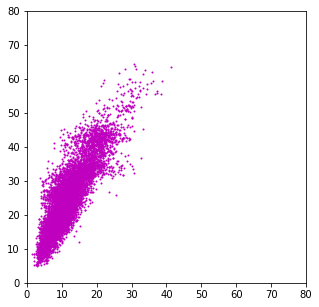

In [53]:
plt.figure(figsize=(5,5))
plt.plot(gs_cl,cl['mean'],'mo',markersize=1)
plt.xlim(0,80)
plt.ylim(0,80)

(0.0, 80.0)

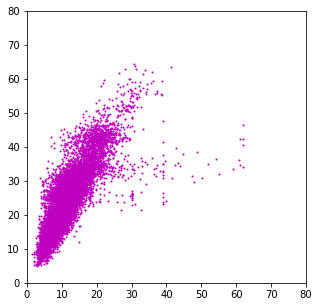

In [34]:
p = pd.DataFrame(index=ct.index,columns=['clay1','clay2'])
p.clay1 = ct.cla
p.clay2 = cl['mean']
p = p.dropna()
plt.figure(figsize=(5,5))
plt.plot(p.clay1,p.clay2,'mo',markersize=1)
plt.xlim(0,80)
plt.ylim(0,80)

In [36]:
dif = p.clay1-p.clay2
dif[dif>0]

401012      4.065132
410761      1.953270
227227      6.238500
225020A     3.796520
226220     15.203161
             ...    
136208A     3.759392
116012A    17.868320
146010A     7.645282
136203A     2.921260
136202D     2.625959
Length: 64, dtype: float64

(0.0, 100.0)

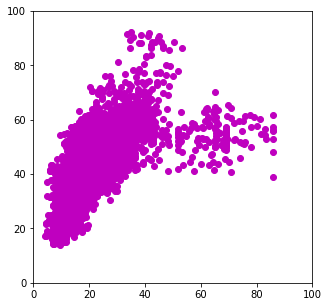

In [30]:
p = pd.DataFrame(index=ct.index,columns=['sa1','sa2'])
p.sa1 = ct.snd
p.sa2 = sa['mean']
p = p.dropna()
plt.figure(figsize=(5,5))
plt.plot(p.sa1,p.sa2,'mo')
plt.xlim(0,100)
plt.ylim(0,100)

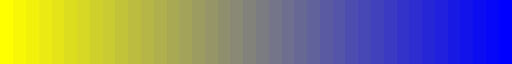

In [84]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

colors=['#ffff00', '#f8f806', '#f1f10c', '#ebeb13', '#e4e419', '#dddd20',
    '#d7d726', '#d0d02d', '#caca33', '#c3c33a', '#bcbc41', '#b6b647',
    '#b0b04e', '#a9a954', '#a3a35a', '#9c9c61', '#959568', '#8f8f6e',
    '#898975', '#82827b', '#7b7b82', '#757589', '#6e6e8f', '#686895',
    '#61619c', '#5a5aa3', '#5454a9', '#4d4db0', '#4747b6', '#4141bc',
    '#3a3ac3', '#3333ca', '#2d2dd0', '#2626d7', '#2020dd', '#1919e4',
    '#1212eb', '#0c0cf1', '#0606f8', '#0000ff']
cmap_vd2 = ListedColormap(colors)
cmap_vd2

Text(0.5, 1.0, '')

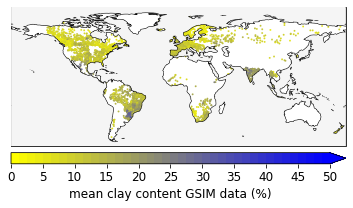

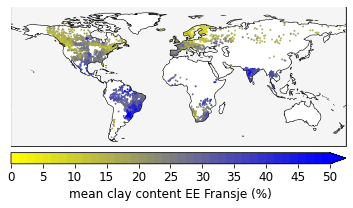

In [93]:
# GSIM CLAY
gs_cl = pd.read_csv(f'{work_dir}/data/GSIM_data/GSIM_metadata/GSIM_catalog/GSIM_catchment_characteristics.csv',index_col=0)
gs_cl.index = [x.lower() for x in gs_cl.index]
gs_cl = gs_cl.loc[cl.index]

bounds = np.linspace(0,50,41)
bounds2 = np.linspace(0,50,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap_vd2.N)

# no irrigation
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(gs_cl['long.new'],gs_cl['lat.new'],s=3,c=gs_cl['scl.mean'],cmap=cmap_vd2, norm=norm,edgecolors='face',marker='o',linewidths=0.1)
cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='max', pad=0.02,aspect=30, norm=norm,ticks=bounds2)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label='mean clay content GSIM data (%)', size=12)
ax.set_title('',size=14)

# EE CLAY
cl = pd.read_csv(f'{work_dir}/output/soil_types/processed/clay.csv',index_col=0)
e = pd.read_csv(f'{work_dir}/output/lat_lon_catchment_outlets.csv', index_col=0)
cl['lat'] = e['lat']
cl['lon'] = e['lon']
cl = cl[0:8000]

bounds = np.linspace(0,50,41)
bounds2 = np.linspace(0,50,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap_vd2.N)

# no irrigation
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(cl['lon'],cl['lat'],s=3,c=cl['mean'],cmap=cmap_vd2, norm=norm,edgecolors='face',marker='o',linewidths=0.1)
cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='max', pad=0.02,aspect=30, norm=norm,ticks=bounds2)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label='mean clay content EE Fransje (%)', size=12)
ax.set_title('',size=14)

In [ ]:
def catch_characteristics_landscape(var_lc,catch_id,work_dir):
    """
    calculate catchment characteristics - landscape variables
    var_lc: define list of landscape variables
    catch_id: catchment id
    returns: dataframe with landscape variables for catchment
    """
    cc_lc = pd.DataFrame(index=[catch_id], columns=var_lc)
    j = catch_id

    if 'tc' in var_lc:
        dft = pd.read_csv(f'{work_dir}/output/treecover/gsim_shapes_treecover.csv',index_col=0) #find treecover tables for catchment
        cc_lc.loc[j,'tc'] = dft.loc[j,'mean_tc'] /100
        cc_lc.loc[j,'ntc'] = dft.loc[j,'mean_ntc']/100
        cc_lc.loc[j,'nonveg'] = dft.loc[j,'mean_nonveg']/100

    if 'area' in var_lc:
        a = pd.read_csv(f'{work_dir}/output/catchment_area.csv',index_col=0)
        cc_lc.loc[j,'area'] = a.loc[j,'area']
        
    if 'el_mean' in var_lc:
        e = pd.read_csv(f'{work_dir}/output/elevation/stats_hydrosheds/ele_{j}.csv',index_col=0)
        e.index = e.index.map(str)
        cc_lc.loc[j,'el_mean'] = e.loc[j,'mean_ele']
        cc_lc.loc[j,'el_max'] = e.loc[j,'max_ele']
        cc_lc.loc[j,'el_min'] = e.loc[j,'min_ele']
        cc_lc.loc[j,'el_std'] = e.loc[j,'std_ele']
    if 'slp_mean' in var_lc:
        e = pd.read_csv(f'{work_dir}/output/elevation/stats_hydrosheds/slope_{j}.csv',index_col=0)
        e.index = e.index.map(str)
        cc_lc.loc[j,'slp_mean'] = e.loc[j,'mean_slope']
        cc_lc.loc[j,'slp_max'] = e.loc[j,'max_slope']
        cc_lc.loc[j,'slp_min'] = e.loc[j,'min_slope']
        cc_lc.loc[j,'slp_std'] = e.loc[j,'std_slope']
    if 'iwu' in var_lc:
        e = pd.read_csv(f'{work_dir}/output/irrigation/processed/mean/{j}.csv',index_col=0)
        e.index = e.index.map(str)
        cc_lc.loc[j,'iwu'] = e.loc[j,'iwu_mean_mmday']
    if 'bp' in var_lc:
        e = pd.read_csv(f'{work_dir}/output/bedrock_depth/0_01deg/{j}.csv',index_col=0)
        e.index = e.index.map(str)
        cc_lc.loc[j,'bp'] = e.loc[j,'bd_perc']
    if 'dtb' in var_lc:
        e = pd.read_csv(f'{work_dir}/output/bedrock_depth/0_05deg/{j}.csv',index_col=0)
        e.index = e.index.map(str)
        cc_lc.loc[j,'dtb'] = e.loc[j,'bd_mean']

    # add gsim variables
    df_gsim = pd.read_csv(f'{work_dir}/data/GSIM_data/GSIM_metadata/GSIM_catalog/GSIM_catchment_characteristics.csv',index_col=0)
    k = j.upper()
    if k in df_gsim.index.values:
        if 'ir_mean' in var_lc:
            cc_lc.loc[j,'ir_mean'] = df_gsim.loc[k,'ir.mean']
        if 'drd' in var_lc:
            cc_lc.loc[j,'drd'] = df_gsim.loc[k,'dr.mean']
        if 'cla' in var_lc:
            cc_lc.loc[j,'cla'] = df_gsim.loc[k,'scl.mean']
        if 'snd' in var_lc:
            cc_lc.loc[j,'snd'] = df_gsim.loc[k,'snd.mean']
        if 'slt' in var_lc:
            cc_lc.loc[j,'slt'] = df_gsim.loc[k,'slt.mean']
        if 'tpi' in var_lc:
            cc_lc.loc[j,'tpi'] = df_gsim.loc[k,'tp.mean']
        if 'lc' in var_lc:
            cc_lc.loc[j,'lc'] = df_gsim.loc[k,'landcover.type']
        if 'lit' in var_lc:
            cc_lc.loc[j,'lit'] = df_gsim.loc[k,'lithology.type']
        if 'pop' in var_lc:
            cc_lc.loc[j,'pop'] = df_gsim.loc[k,'pop.count']
        if 'pd' in var_lc:
            cc_lc.loc[j,'pd'] = df_gsim.loc[k,'pd.mean']
        if 'st' in var_lc:
            cc_lc.loc[j,'st'] = df_gsim.loc[k,'soil.type']
        if 'nld' in var_lc:
            cc_lc.loc[j,'nld'] = df_gsim.loc[k,'nl.mean']
        if 'ds' in var_lc:
            cc_lc.loc[j,'ds'] = df_gsim.loc[k,'no.dams']
        if 'dv' in var_lc:
            cc_lc.loc[j,'dv'] = df_gsim.loc[k,'sto.volume']
        if 'clt' in var_lc:
            cc_lc.loc[j,'clt'] = df_gsim.loc[k,'climate.type']
    else:
        # use aus information
        df_aus = pd.read_csv(f'{work_dir}/data/CAMELS_AUS/CAMELS_AUS_Attributes-Indices_MasterTable.csv',index_col=0)
        cc_lc.loc[j,['drd','cla','snd']] = df_aus.loc[j,['strdensity','claya','sanda']].values  
        cc_lc.loc[j,['ir_mean','slt','tpi','lc','lit','pop','pd','st','nld','ds','dv','clt']] = np.nan # not available for camels aus   
    return cc_lc

In [5]:
# define in and output folder
var_lc=['tc','ntc','nonveg','area','ir_mean','el_mean','el_min','el_max','el_std','drd','slp_mean','slp_max','slp_min','slp_std','cla','snd','slt','tpi','bp','dtb','iwu','ds','dv','pd','pop','nld','clt','lc','lit']
var_cl=['p_mean','ep_mean','q_mean','t_mean','ai','hai','tdiff_max','tdiff_mean','idu_mean','idu_max','hpd_mean','hpd_max','hpf','lpf','si_p','si_ep','phi','de','dp','dt','sp','st','se','sd','sti','ftf']
var_sn=['idu_mean_l','idu_max_l','hpd_mean_l','hpd_max_l','hpf_l','lpf_l','si_pl','phi_l','de_l','dp_l','dt_l','sp_l','st_l','se_l','sd_l','sti_l']

catch_id_list = np.genfromtxt(f'{work_dir}/output/gsim_aus_catch_id_list_lo_sel.txt',dtype='str')[:] # test for 3 catchments -> run on delftblue for all catchments with catch_characteristics.py

data_sources = 'gswp-p_gleam-ep_gswp-t'

# check which characteristics are already processed, only process new ones
cc = pd.read_csv(f'{work_dir}/output/catchment_characteristics/catchment_characteristics_{data_sources}.csv',index_col=0)
col = cc.columns #variables in col are already processed

# make lists of variables that are not processed yet
var_lc = list(set(var_lc) - set(col))
var_cl = list(set(var_cl) - set(col))
var_sn = list(set(var_sn) - set(col))

In [6]:
# make lists for parallel computation
catch_list = catch_id_list.tolist()
var_lc_list = [var_lc] * len(catch_list)
var_cl_list = [var_cl] * len(catch_list)
var_sn_list = [var_sn] * len(catch_list)
work_dir_list = [work_dir] * len(catch_list)
data_sources_list = [data_sources] * len(catch_list)

# run catch_characteristics (defined in f_catch_characteristics.py) for the catchments in your catch_id_list parallel
run_function_parallel_catch_characteristics(var_lc_list,var_cl_list,var_sn_list,catch_list,work_dir_list,data_sources_list)
print('done')

KeyboardInterrupt: 

In [7]:
# check which catchments are missing
catch_list = np.genfromtxt(f'{work_dir}/output/gsim_aus_catch_id_list_lo_sel.txt',dtype='str')
id_list=[]
for filepath in glob.iglob(f'{work_dir}/output/catchment_characteristics/gswp-p_gleam-ep_gswp-t/*.csv'):
    f = os.path.split(filepath)[1] # remove full path
    f = f[:-4] # remove .csv extension
    id_list.append(f)
dif = list(set(catch_list) - set(id_list))
len(dif)

127

In [6]:
#combine all files in one dataframe
data_sources = 'gswp-p_gleam-ep_gswp-t'
# list al shapefiles    
files = glob.glob(f"{work_dir}/output/catchment_characteristics/{data_sources}/*")
li=[] #empty list
for filename in files:
    df = pd.read_csv(filename, index_col=0) #read file as dataframe
    li.append(df) #append file to list
f = pd.concat(li, axis=0) #concatenate lists
f.to_csv(f'{work_dir}/output/catchment_characteristics/catchment_characteristics_{data_sources}.csv')

In [9]:
# combine catchment geometries in single shapefile
shapefiles = glob.glob(f"{work_dir}/output/selected_shapes/*shp")[:]
li=[] #empty list
for filename in shapefiles:
    df = gpd.read_file(filename, index_col=None, header=0) #read shapefile as geopandas dataframe
    li.append(df) #append shapefile to list
f = pd.concat(li, axis=0) #concatenate lists
f = f.rename(columns={'FILENAME':'catch_id'})
f.index = f['catch_id']
f = f.drop(columns={'catch_id','Id'})
f.to_file(f'{out_dir}/geo_catchments.shp') #store geopandas dataframe as .shp

In [11]:
# fix australia shapes
a=gpd.read_file(f'{out_dir}/geo_catchments.shp')
a[8436:].catch_id = a[8436:].catch_id
# a = a.drop(columns={'CatchID'})
a.to_file(f'{out_dir}/geo_catchments.shp') #store geopandas dataframe as .shp

/home/fransjevanoors/miniconda3/envs/sr_env/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [8]:
# add lat - lon to catchment characteristics
a=gpd.read_file(f'{work_dir}/output/geo_catchments.shp')
a.index=a['catch_id']
a = a.to_crs(4326)
a['centroid'] = a.centroid
lon = a.centroid.x
lat = a.centroid.y
# a.centroid.point_object.x
# a.point_object.x

c = pd.read_csv(f'{work_dir}/output/catchment_characteristics/catchment_characteristics_{data_sources}.csv',index_col=0)
c['lat'] = lat
c['lon'] = lon
c.to_csv(f'{work_dir}/output/catchment_characteristics/catchment_characteristics_{data_sources}.csv')
c

/tmp/ipykernel_1289857/3438770681.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  a['centroid'] = a.centroid
/tmp/ipykernel_1289857/3438770681.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lon = a.centroid.x
/tmp/ipykernel_1289857/3438770681.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lat = a.centroid.y


,p_mean,ep_mean,q_mean,t_mean,ai,hai,tdiff_max,tdiff_mean,idu_mean,idu_max,...,dv,pd,pop,nld,clt,lc,lit,st.1,lat,lon
de_0000778,4.045309,2.057641,0.842493,7.638991,1.965994,0.337366,24.641665,20.637500,2.86,16.13,...,0.0,22.02160,14377.860,0.241560,Snow,Forest,Unconsolidated sediments,NaN,47.723927,11.933343
br_0001850,4.186528,2.943133,1.030596,25.107997,1.422473,0.967762,6.181352,4.359281,7.14,72.03,...,0.0,27.11160,201182.800,0.491105,Equatorial,Agriculture,Acid plutonic rocks,NaN,-16.616687,-49.718967
ca_0003156,1.235331,1.331096,0.017540,3.742158,0.928056,1.003734,43.900205,36.056585,5.33,30.03,...,813.0,1.07419,46994.660,0.315056,Snow,Agriculture,Siliciclastic sedimentary rocks,NaN,49.506681,-103.275867
br_0001299,3.123837,2.907271,1.032392,24.338485,1.074491,1.257753,6.634216,5.093589,4.47,24.80,...,0.0,2.69709,12372.820,0.411808,Equatorial,No dominant class,Metamorphics,NaN,-17.108293,-39.967427
br_0001843,4.453621,2.944259,1.377108,24.223189,1.512646,0.877896,6.469796,4.538261,7.15,73.73,...,0.0,218.07500,2077434.000,0.342362,Equatorial,Agriculture,Metamorphics,NaN,-16.539263,-49.184522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ca_0001384,3.196726,1.852481,2.053996,2.880652,1.725645,0.341004,40.004254,33.168757,2.74,11.63,...,0.0,1.17995,12177.410,NaN,Snow,Forest,Metamorphics,NaN,47.253879,-72.245291
us_0001647,3.412146,2.749842,2.050785,18.061075,1.240852,0.855017,24.183295,20.816630,4.07,18.73,...,0.0,22.21370,2942.327,0.320770,Warm Temperate,Forest,Metamorphics,NaN,33.018864,-83.604070
gb_0000044,2.269773,1.157692,1.016338,9.472414,1.960603,0.677501,17.949959,13.999706,3.36,17.43,...,0.0,537.57700,312431.700,0.299489,Warm Temperate,Agriculture,Carbonate sedimentary rocks,NaN,53.261171,-1.396872
br_0000392,4.171185,3.215613,1.172224,25.953768,1.297166,1.004279,4.744549,3.214524,9.28,87.60,...,56782.0,4.07883,1688865.000,NaN,Equatorial,Shrubland,No dominant class,NaN,-12.531370,-47.860721


In [9]:
## add some australia GSIM characteristics to cc dataframe
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/catchment_characteristics_gswp-p_gleam-ep_gswp-t.csv',index_col=0)
non_aus=[]
aus=[]
for i in df.index:
    if ('_' in i):
        non_aus.append(i)
    else:
        aus.append(i)
print('len aus: ',len(aus))
print('len non aus: ',len(non_aus))
print('len total: ',len(aus)+len(non_aus))

gs = pd.read_csv(f'{work_dir}/data/GSIM_data/GSIM_metadata/GSIM_catalog/GSIM_metadata.csv',index_col=0)
gs_aus = gs[271:3212] #select australia catchments

aus_df = pd.DataFrame(index=aus, columns=gs_aus.columns)
cids = []
for i in range(len(gs_aus)):
    if (gs_aus.iloc[i]['reference.no']) in aus:
        cids.append(i)
        
gs_aus_sel = gs_aus.iloc[cids]
gs_aus_sel2 = gs_aus_sel['reference.no'].values
gs_aus_sel = gs_aus_sel.index

d = pd.read_csv(f'{work_dir}/data/GSIM_data/GSIM_metadata/GSIM_catalog/GSIM_catchment_characteristics.csv',index_col=0)
d = d.loc[gs_aus_sel]
d['id'] = gs_aus_sel2
d['gsim.no'] = d.index
d.index = d['id']

len aus:  222
len non aus:  8436
len total:  8658


In [10]:
d

,long.org,lat.org,long.new,lat.new,dist.km,area.meta,area.est,quality,altitude.meta,altitude.dem,...,slt.max,soil.type,tp.mean,tp.min,tp.q1,tp.q2,tp.q3,tp.max,id,gsim.no
id,,,,,,,,,,,,,,,,,,,,,
102101A,142.984523,-12.879744,NaN,NaN,NaN,NaN,645.810807,Caution,NaN,75.0,...,22.0,Ferralsols,2.957660,0.0,0.0,2.794343,5.210314,15.47600,102101A,AU_0000017
104001A,143.394002,-14.167489,NaN,NaN,NaN,NaN,468.748987,Caution,NaN,68.0,...,21.0,Ferralsols,2.821050,0.0,0.0,2.527938,5.027233,14.54050,104001A,AU_0000019
105101A,144.838700,-15.281600,NaN,NaN,NaN,NaN,0.206080,Caution,NaN,88.0,...,13.0,Ferralsols,0.976079,0.0,0.0,0.000000,0.976079,3.90432,105101A,AU_0000021
105102A,144.484770,-15.613720,NaN,NaN,NaN,NaN,1348.488222,Caution,NaN,94.0,...,18.0,Lixisols,2.988430,0.0,0.0,2.753608,5.021879,15.60130,105102A,AU_0000022
105105A,145.012970,-15.767990,NaN,NaN,NaN,NaN,292.767067,Caution,NaN,163.0,...,23.0,Ferralsols,2.343960,0.0,0.0,0.000000,3.923076,14.76540,105105A,AU_0000023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
G8170002,131.108600,-13.241480,NaN,NaN,NaN,NaN,692.903000,Caution,NaN,54.0,...,20.0,Ferralsols,3.578650,0.0,0.0,4.112106,5.721510,15.30240,G8170002,AU_0002918
G8190001,132.174900,-12.792110,NaN,NaN,NaN,NaN,248.331100,Caution,NaN,25.0,...,17.0,Ferralsols,4.304130,0.0,0.0,5.210682,6.596503,14.23300,G8190001,AU_0002931
G8200045,132.871800,-13.881290,NaN,NaN,NaN,NaN,0.207395,Caution,NaN,325.0,...,13.0,Ferralsols,2.441100,0.0,0.0,2.166445,4.607549,5.43152,G8200045,AU_0002932


In [39]:
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/catchment_characteristics_gswp-p_gleam-ep_gswp-t.csv',index_col=0)
df.loc[d.index]['ir_mean'] = d.loc[d.index]['ir.mean']
for i in d.index:
    df.loc[i,'ir_mean'] = d.loc[i,'ir.mean']
df.to_csv(f'{work_dir}/output/catchment_characteristics/catchment_characteristics_gswp-p_gleam-ep_gswp-t.csv')

### add lat lon of catchment outlet to catchment characteristics

In [10]:
data_sources = 'gswp-p_gleam-ep_gswp-t'
c = pd.read_csv(f'{work_dir}/output/catchment_characteristics/catchment_characteristics_{data_sources}.csv',index_col=0)
c[['lat','lon']]

,lat,lon
de_0000778,47.889600,11.831200
br_0001850,-17.106300,-49.689600
ca_0003156,48.989600,-101.956300
br_0001299,-17.252100,-39.622900
br_0001843,-16.956300,-49.077100
...,...,...
ITVEN429,46.559269,12.547678
ITVEN430,46.011668,11.913261
ITVEN433,46.595520,12.108680
ITVEN434,46.134401,12.218303


### 8. Select catchments based on area and water balance
- Area < 10000
- P > Q \
Save catchment characteristics dataframe of selected catchments as *catchment_characteristics_sel_area_wb.csv*, catch id list as *gsim_aus_catch_id_list_lo_sel_area_wb.txt*, and geo table *geo_catchments_sel_area_wb.shp* \
We select then 6422/8658 catchments

In [9]:
# catchment characteristics
c = pd.read_csv(f'{work_dir}/output/catchment_characteristics/catchment_characteristics_gswp-p_gleam-ep_gswp-t.csv',index_col=0)
c = c[c.area<10000]
c = c[c.p_mean>c.q_mean]
# c.to_csv(f'{out_dir}/catchment_characteristics_sel_area_wb.csv')

# catchment id list
catch_id = c.index.values
np.savetxt(f'{work_dir}/output/gsim_aus_catch_id_list_lo_sel_area_wb.txt',catch_id,fmt='%s')

# geopandas table
a=gpd.read_file(f'{work_dir}/output/geo_catchments.shp')
a.index = a.catch_id
a = a.loc[c.index]
a.to_file(f'{work_dir}/output/geo_catchments_sel_area_wb.shp') #store geopandas dataframe as .shp